In [53]:
import os
import sys
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from google.colab import drive
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import shap
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
def score_distanceM(Xobserve,Yobserve,Xprevu,Yprevu):
  X=(Xobserve-Xprevu)**2
  Y=(Yobserve-Yprevu)**2
  return np.mean(np.sqrt(X+Y))

In [55]:
cd /content/drive/My\ Drive/Colab\ Notebooks/

/content/drive/My Drive/Colab Notebooks


In [56]:
df_init=pd.read_csv('data_v6.csv')
dfbase=df_init.copy()
dfbase=dfbase.sample(frac=1).reset_index(drop=True)

df_init_complet=pd.read_csv('complet.csv')
dfcomplet=df_init_complet.copy()
dfcomplet=dfcomplet.sample(frac=1).reset_index(drop=True)



In [57]:
feature_choice=['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x','loc_target_y','loc_initiator_x','loc_initiator_y',
                'rssi_request','rssi_ack','rssi_data','rssi_mean','temperature_initiator','temperature_target','range','range_skew','orientation']

In [58]:
dfbase=dfbase[feature_choice]
dfcomplet=dfcomplet[feature_choice+['origin','rotation']]

In [59]:
def score_alpha(y_test,y_pred,alpha):
  df_score=pd.DataFrame({'ecart':np.sqrt((y_pred-y_test).loc_initiator_y**2+(y_pred-y_test).loc_initiator_x**2)})
  return len(df_score[df_score.ecart<alpha])/len(df_score)

## 1er cas


On fixe les données de validations à l'ensemble des données du capteur 184
on n'utilise que les données de dfbase pour le train


In [60]:
df_184=dfbase[dfbase.target==184]

In [61]:
df=dfbase[dfbase.target!=184]
df_184=dfbase[dfbase.target==184]
X=df[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x',
      'loc_target_y','rssi_request','rssi_ack','rssi_data','rssi_mean',
      'temperature_initiator','temperature_target','range','range_skew','orientation']]
y=df[['loc_initiator_x','loc_initiator_y']]

X_validation=df_184[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_request','rssi_ack','rssi_data','rssi_mean','temperature_initiator','temperature_target','range',
                     'range_skew','orientation']]

y_validation=df_184[['loc_initiator_x','loc_initiator_y']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
MOR=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror')).fit(X_train, y_train)
y_pred = MOR.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print(score_alpha(y_test,y_pred,0.02))
print("RMSE : % f" %(rmse))


0.05925925925925926
RMSE :  0.055955


In [62]:
y_pred = MOR.predict(X_validation)
print(score_alpha(y_pred,y_validation,0.02))
rmse = mean_squared_error(y_validation, y_pred)
print("RMSE : % f" %(rmse))


0.015536723163841809
RMSE :  0.122343


## 2eme cas


On fixe les données de train à l'ensemble des données du plan de base et la validation les autres plans

In [63]:
df_sans_plan_base=dfcomplet[(dfcomplet['origin']!=0) | (dfcomplet['rotation']!=0)]
X_validation=df_sans_plan_base[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_request','rssi_ack','rssi_data','rssi_mean','temperature_initiator','temperature_target','range',
                     'range_skew','orientation']]


y_validation=df_sans_plan_base[['loc_initiator_x','loc_initiator_y']]

X=dfbase[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x',
      'loc_target_y','rssi_request','rssi_ack','rssi_data','rssi_mean',
      'temperature_initiator','temperature_target','range','range_skew','orientation']]
y=dfbase[['loc_initiator_x','loc_initiator_y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
MOR=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror')).fit(X_train, y_train)
y_pred = MOR.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print('score sur le test seuil de 0.02   :', score_alpha(y_test,y_pred,0.02))
print("RMSE sur le test : % f" %(rmse))

y_pred = MOR.predict(X_validation)
print(score_alpha(y_pred,y_validation,1))
rmse = mean_squared_error(y_validation, y_pred)
print("RMSE : % f" %(rmse))


score sur le test seuil de 0.02   : 0.0790273556231003
RMSE sur le test :  0.059433
0.002031268275566299
RMSE :  37.410464


Il y a du sur apprentisage car on s'écarte de ralité de 38m environ

## 3eme cas


On fixe les données de validation à l'ensemble des données du plan de base et le train à l'ensemble des données sans le plan de base

In [64]:
X=df_sans_plan_base[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_request','rssi_ack','rssi_data','rssi_mean','temperature_initiator','temperature_target','range',
                     'range_skew','orientation']]
y=df_sans_plan_base[['loc_initiator_x','loc_initiator_y']]

X_validation=dfbase[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_request','rssi_ack','rssi_data','rssi_mean','temperature_initiator','temperature_target','range',
                     'range_skew','orientation']]

y_validation=dfbase[['loc_initiator_x','loc_initiator_y']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
MOR=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror')).fit(X_train, y_train)
y_pred = MOR.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print('score sur le test seuil de 0.02   :', score_alpha(y_test,y_pred,0.02))
print("RMSE sur le test : % f" %(rmse))
y_pred = MOR.predict(X_validation)
print('score sur la test validation de 0.02  :', score_alpha(y_pred,y_validation,0.10))
rmse = mean_squared_error(y_validation, y_pred)
print("RMSE sur la validation: % f" %(rmse))

score sur le test seuil de 0.02   : 6.238011321990549e-05
RMSE sur le test :  3.220512
score sur la test validation de 0.02  : 0.0
RMSE sur la validation:  6.357276


## Selection de feature

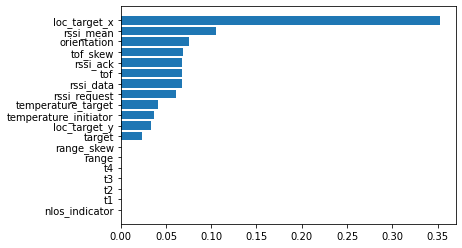

In [65]:
features = MOR.estimators_[0].feature_importances_
features
#wo_interaction_terms = pd.DataFrame({'importance':features},index=list(X_train.columns())).sort_values('importance', ascending=False)
df_importance=pd.DataFrame({'importance':features ,'variable':X_train.columns}).sort_values('importance')

plt.barh(range(len(df_importance)), df_importance.importance)
 
# Create names on the x-axis
plt.yticks(range(len(df_importance)), df_importance.variable)
 
# Show graphic
plt.show()

In [66]:
X=df_sans_plan_base[['target','nlos_indicator','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_ack','rssi_data','temperature_initiator','temperature_target','orientation']]

y=df_sans_plan_base[['loc_initiator_x','loc_initiator_y']]

X_validation=dfbase[['target','nlos_indicator','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_ack','rssi_data','temperature_initiator','temperature_target','orientation']]

y_validation=dfbase[['loc_initiator_x','loc_initiator_y']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
MOR=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror')).fit(X_train, y_train)
y_pred = MOR.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print('score sur le test seuil de 0.02   :', score_alpha(y_test,y_pred,0.02))
print("RMSE sur le test : % f" %(rmse))
y_pred = MOR.predict(X_validation)
print('score sur la test validation de 0.02  :', score_alpha(y_pred,y_validation,0.02))
rmse = mean_squared_error(y_validation, y_pred)
print("RMSE sur la validation: % f" %(rmse))


score sur le test seuil de 0.02   : 0.00012476022643981099
RMSE sur le test :  3.210666
score sur la test validation de 0.02  : 0.0
RMSE sur la validation:  6.339504


In [67]:
score_distanceM(y_validation.loc_initiator_x, y_validation.loc_initiator_y,y_pred[:,0],y_pred[:,1])

3.3380217457948542

## Test de prediction sans MultiOutputRegressor (sur x et sur y)

 ### prediction X


In [21]:
X=df_sans_plan_base[['target','nlos_indicator','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_ack','rssi_data','temperature_initiator','temperature_target','orientation']]

y=df_sans_plan_base['loc_initiator_x']

X_validation=dfbase[['target','nlos_indicator','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_ack','rssi_data','temperature_initiator','temperature_target','orientation']]

y_validation_x=dfbase['loc_initiator_x']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
XG=xgb.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)
y_pred = XG.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
#print('score sur le test seuil de 0.02   :', score_alpha(y_test,y_pred,0.02))
print("RMSE sur le test : % f" %(rmse))
y_pred_x = XG.predict(X_validation)
#print('score sur la test validation de 0.02  :', score_alpha(y_pred_x,y_validation,0.02))
rmse = mean_squared_error(y_validation_x, y_pred_x)
print("RMSE sur la validation: % f" %(rmse))

RMSE sur le test :  3.143495
RMSE sur la validation:  3.320859


 ### prediction Y

In [22]:
X=df_sans_plan_base[['target','nlos_indicator','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_ack','rssi_data','temperature_initiator','temperature_target','orientation']]

y=df_sans_plan_base['loc_initiator_y']

X_validation=dfbase[['target','nlos_indicator','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_ack','rssi_data','temperature_initiator','temperature_target','orientation']]

y_validation_y=dfbase['loc_initiator_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
XG=xgb.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)
y_pred = XG.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
#print('score sur le test seuil de 0.02   :', score_alpha(y_test,y_pred,0.02))
print("RMSE sur le test : % f" %(rmse))
y_pred_y = XG.predict(X_validation)
#print('score sur la test validation de 0.02  :', score_alpha(y_pred_x,y_validation,0.02))
rmse = mean_squared_error(y_validation_y, y_pred_y)
print("RMSE sur la validation: % f" %(rmse))

RMSE sur le test :  3.655305
RMSE sur la validation:  9.826254


### score

In [23]:
score_distanceM(y_validation_x, y_validation_y,y_pred_x,y_pred_y)

3.38494327950185

C'est pareil que avec la méthode MultiOutputRegressor

##Application scenario 1

###prediction x

In [24]:
df=dfbase[dfbase.target!=171]
df_171=dfbase[dfbase.target==171]
X=df[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x',
      'loc_target_y','rssi_request','rssi_ack','rssi_data','rssi_mean',
      'temperature_initiator','temperature_target','range','range_skew','orientation']]
y=df['loc_initiator_x']

X_validation=df_171[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_request','rssi_ack','rssi_data','rssi_mean','temperature_initiator','temperature_target','range',
                     'range_skew','orientation']]

y_validation_x=df_171['loc_initiator_x']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
XG_x=xgb.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)
y_pred = XG_x.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)

print('MAE    :',mean_absolute_error(y_test, y_pred))
print("RMSE : % f" %(rmse))
print('score   :',XG_x.score(X_test,y_test))
print('validation croisé  :',cross_val_score(XG_x,X_test,y_test))

MAE    : 0.12041921410472305
RMSE :  0.031153
score   : 0.9675238221594209
validation croisé  : [0.94757266 0.94665954 0.9242968  0.93783504 0.92873019]


In [25]:
y_pred_x = XG_x.predict(X_validation)
print('MAE    :',mean_absolute_error(y_validation_x, y_pred_x))
rmse = mean_squared_error(y_validation_x, y_pred_x)
print("RMSE : % f" %(rmse))


MAE    : 0.24720484730214048
RMSE :  0.082456


###prediction y

In [26]:
df=dfbase[dfbase.target!=171]
df_171=dfbase[dfbase.target==171]
X=df[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x',
      'loc_target_y','rssi_request','rssi_ack','rssi_data','rssi_mean',
      'temperature_initiator','temperature_target','range','range_skew','orientation']]
y=df['loc_initiator_y']

X_validation=df_171[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_request','rssi_ack','rssi_data','rssi_mean','temperature_initiator','temperature_target','range',
                     'range_skew','orientation']]

y_validation_y=df_171['loc_initiator_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
XG_y=xgb.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)
y_pred = XG_y.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)

print('MAE    :',mean_absolute_error(y_test, y_pred))
print("RMSE : % f" %(rmse))
print('score   :',XG_y.score(X_test,y_test))
print('validation croisé  :',cross_val_score(XG_y,X_test,y_test))

MAE    : 0.21528861874003472
RMSE :  0.100821
score   : 0.9676418705603218
validation croisé  : [0.94453763 0.94634805 0.92348819 0.93789907 0.92731689]


In [27]:
y_pred_y = XG_y.predict(X_validation)
print('MAE    :',mean_absolute_error(y_validation_y, y_pred_y))
rmse = mean_squared_error(y_validation_y, y_pred_y)
print("RMSE : % f" %(rmse))

MAE    : 0.402691803953742
RMSE :  0.227225


###score

In [29]:
score_distanceM(y_validation_x, y_validation_y,y_pred_x,y_pred_y)

0.47519682517514417

##Selection de feature

###Pour y

Méthode feature_importances_

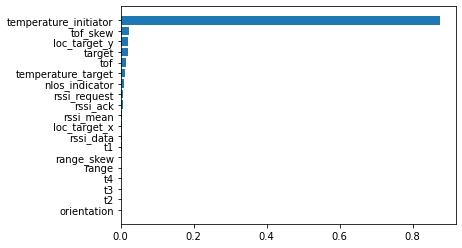

In [30]:
features = XG_y.feature_importances_
features
#wo_interaction_terms = pd.DataFrame({'importance':features},index=list(X_train.columns())).sort_values('importance', ascending=False)
df_importance=pd.DataFrame({'importance':features ,'variable':X_train.columns}).sort_values('importance')

plt.barh(range(len(df_importance)), df_importance.importance)
 
# Create names on the x-axis
plt.yticks(range(len(df_importance)), df_importance.variable)
 
# Show graphic
plt.show()

In [31]:
df=dfbase[dfbase.target!=171]
df_171=dfbase[dfbase.target==171]
X=df[list(df_importance[df_importance.importance>0].variable)]
y=df['loc_initiator_y']

X_validation=df_171[list(df_importance[df_importance.importance>0].variable)]

y_validation_y=df_171['loc_initiator_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
XG_y=xgb.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)
y_pred = XG_y.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)

print('MAE    :',mean_absolute_error(y_test, y_pred))
print("RMSE : % f" %(rmse))
print('score   :',XG_y.score(X_test,y_test))
print('validation croisé  :',cross_val_score(XG_y,X_test,y_test))
y_pred_y = XG_y.predict(X_validation)
print('MAE validation    :',mean_absolute_error(y_validation_y, y_pred_y))
rmse = mean_squared_error(y_validation_y, y_pred_y)
print("RMSE validation : % f" %(rmse))

MAE    : 0.21525828718727022
RMSE :  0.100855
score   : 0.9676309218103456
validation croisé  : [0.94465783 0.94582204 0.92348846 0.93775953 0.92731689]
MAE validation    : 0.40671206460295434
RMSE validation :  0.231115


Méthode shap

In [32]:
df=dfbase[dfbase.target!=171]
df_171=dfbase[dfbase.target==171]
X=df[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x',
      'loc_target_y','rssi_request','rssi_ack','rssi_data','rssi_mean',
      'temperature_initiator','temperature_target','range','range_skew','orientation']]
y=df['loc_initiator_y']

X_validation=df_171[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_request','rssi_ack','rssi_data','rssi_mean','temperature_initiator','temperature_target','range',
                     'range_skew','orientation']]

y_validation_y=df_171['loc_initiator_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
XG_y=xgb.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)
y_pred = XG_y.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)

print('MAE    :',mean_absolute_error(y_test, y_pred))
print("RMSE : % f" %(rmse))
print('score   :',XG_y.score(X_test,y_test))
print('validation croisé  :',cross_val_score(XG_y,X_test,y_test))

MAE    : 0.21528861874003472
RMSE :  0.100821
score   : 0.9676418705603218
validation croisé  : [0.94453763 0.94634805 0.92348819 0.93789907 0.92731689]


In [ ]:
plt.

In [33]:
explainer=shap.TreeExplainer(XG_y)
shap_values=explainer.shap_values(X_test)

In [34]:
df_importance=pd.DataFrame({'importance':shap_values[0] ,'variable':X_train.columns}).sort_values('importance')


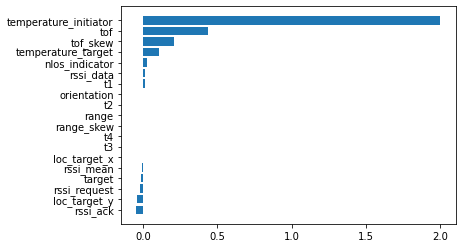

In [35]:
plt.barh(range(len(df_importance)), df_importance.importance)
 
# Create names on the x-axis
plt.yticks(range(len(df_importance)), df_importance.variable)
 
# Show graphic
plt.show()

In [36]:
df=dfbase[dfbase.target!=171]
df_171=dfbase[dfbase.target==171]
X=df[list(df_importance[(df_importance['importance']>0.02) | (df_importance['importance']<-0.02)].variable)]
y=df['loc_initiator_y']

X_validation=df_171[list(df_importance[(df_importance['importance']>0.02) | (df_importance['importance']<-0.02)].variable)]

y_validation_y=df_171['loc_initiator_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
XG_y=xgb.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)
y_pred = XG_y.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)

print('MAE    :',mean_absolute_error(y_test, y_pred))
print("RMSE : % f" %(rmse))
print('score   :',XG_y.score(X_test,y_test))
print('validation croisé  :',cross_val_score(XG_y,X_test,y_test))

MAE    : 0.21068705719841851
RMSE :  0.098195
score   : 0.9684845307711467
validation croisé  : [0.94676412 0.95092407 0.92361233 0.94062112 0.9288327 ]


In [37]:
y_pred_y = XG_y.predict(X_validation)
print('MAE    :',mean_absolute_error(y_validation_y, y_pred_y))
rmse = mean_squared_error(y_validation_y, y_pred_y)
print("RMSE : % f" %(rmse))

MAE    : 0.4325922750968718
RMSE :  0.261387


Shap est meilleur

###Pour x

Méthode feature_importances_

In [41]:
df=dfbase[dfbase.target!=171]
df_171=dfbase[dfbase.target==171]
X=df[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x',
      'loc_target_y','rssi_request','rssi_ack','rssi_data','rssi_mean',
      'temperature_initiator','temperature_target','range','range_skew','orientation']]
y=df['loc_initiator_x']

X_validation=df_171[['target','nlos_indicator','t1','t2','t3','t4','tof','tof_skew','loc_target_x','loc_target_y',
                     'rssi_request','rssi_ack','rssi_data','rssi_mean','temperature_initiator','temperature_target','range',
                     'range_skew','orientation']]

y_validation_x=df_171['loc_initiator_x']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
XG_x=xgb.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)
y_pred = XG_x.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)

print('MAE    :',mean_absolute_error(y_test, y_pred))
print("RMSE : % f" %(rmse))
print('score   :',XG_x.score(X_test,y_test))
print('validation croisé  :',cross_val_score(XG_x,X_test,y_test))

MAE    : 0.12041921410472305
RMSE :  0.031153
score   : 0.9675238221594209
validation croisé  : [0.94757266 0.94665954 0.9242968  0.93783504 0.92873019]


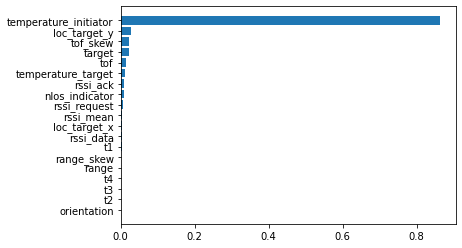

In [39]:
features = XG_x.feature_importances_
features
#wo_interaction_terms = pd.DataFrame({'importance':features},index=list(X_train.columns())).sort_values('importance', ascending=False)
df_importance=pd.DataFrame({'importance':features ,'variable':X_train.columns}).sort_values('importance')

plt.barh(range(len(df_importance)), df_importance.importance)
 
# Create names on the x-axis
plt.yticks(range(len(df_importance)), df_importance.variable)
 
# Show graphic
plt.show()

In [40]:
df=dfbase[dfbase.target!=171]
df_171=dfbase[dfbase.target==171]
X=df[list(df_importance[df_importance.importance>0].variable)]
y=df['loc_initiator_x']

X_validation=df_171[list(df_importance[df_importance.importance>0].variable)]

y_validation_x=df_171['loc_initiator_x']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
XG_x=xgb.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)
y_pred = XG_x.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)

print('MAE    :',mean_absolute_error(y_test, y_pred))
print("RMSE : % f" %(rmse))
print('score   :',XG_x.score(X_test,y_test))
print('validation croisé  :',cross_val_score(XG_x,X_test,y_test))
y_pred_x = XG_x.predict(X_validation)
print('MAE validation    :',mean_absolute_error(y_validation_y, y_pred_y))
rmse = mean_squared_error(y_validation_x, y_pred_x)
print("RMSE validation : % f" %(rmse))

MAE    : 0.12031457086580771
RMSE :  0.031135
score   : 0.9675429635293066
validation croisé  : [0.94761151 0.94628356 0.92399489 0.93784209 0.92873019]
MAE validation    : 0.4325922750968718
RMSE validation :  0.084167


Méthode shap

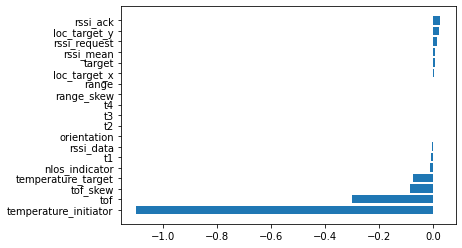

In [42]:
explainer=shap.TreeExplainer(XG_x)
shap_values=explainer.shap_values(X_test)
df_importance=pd.DataFrame({'importance':shap_values[0] ,'variable':X_train.columns}).sort_values('importance')
plt.barh(range(len(df_importance)), df_importance.importance)
 
# Create names on the x-axis
plt.yticks(range(len(df_importance)), df_importance.variable)
 
# Show graphic
plt.show()

In [72]:
df=dfbase[dfbase.target!=171]
df_171=dfbase[dfbase.target==171]
X=df[list(df_importance[(df_importance['importance']>0.02) | (df_importance['importance']<-0.02)].variable)]
y=df['loc_initiator_x']

X_validation=df_171[list(df_importance[(df_importance['importance']>0.02) | (df_importance['importance']<-0.02)].variable)]

y_validation_x=df_171['loc_initiator_x']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
XG_x=xgb.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)
y_pred = XG_x.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)

print('MAE    :',mean_absolute_error(y_test, y_pred))
print("RMSE : % f" %(rmse))
print('score   :',XG_x.score(X_test,y_test))
print('validation croisé  :',cross_val_score(XG_x,X_test,y_test))
y_pred_x = XG_x.predict(X_validation)
print('MAE validation    :',mean_absolute_error(y_validation_y, y_pred_y))
rmse = mean_squared_error(y_validation_x, y_pred_x)
print("RMSE validation : % f" %(rmse))

MAE    : 0.11100952980403689
RMSE :  0.025363
score   : 0.9736450270524548
validation croisé  : [0.96407495 0.95605292 0.97276986 0.94323726 0.93951861]
MAE validation    : 0.4325922750968718
RMSE validation :  0.010630


In [73]:
score_distanceM(y_validation_x, y_validation_y,y_pred_x,y_pred_y)

0.44438492486284303

##Recherche parametres optimums

In [75]:
param_grid = {'max_depth': [6],
              'learning_rate': [0.1],
              'n_estimators': [1000],
              'min_child_weight':[0],
              'subsample' :[0.75,0.8,0.9],
              'sampling_method':['gradient_based'],
              'colsample_by*':[0.001,0.005],
              'refresh_leaf':[0,1],
              'process_type':['default']
              }

# create an instance of GridSearchCV
grid_search = GridSearchCV(XG_x, param_grid, cv=5)

# fit the grid search to the data
grid_search.fit(X_train, y_train)

# print the best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best parameters score: ", grid_search.best_score_)

Best parameters found:  {'colsample_by*': 0.001, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 0, 'n_estimators': 1000, 'process_type': 'default', 'refresh_leaf': 0, 'sampling_method': 'gradient_based', 'subsample': 0.9}
Best parameters score:  0.9868496500034748


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}
Best parameters score:  0.9875367673934623

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 600}
Best parameters score:  0.9875561179789847

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 0, 'n_estimators': 600, 'subsample': 0.5}
Best parameters score:  0.9877791966135803

Best parameters found:  {'colsample_by*': 0.01, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 0, 'n_estimators': 600, 'sampling_method': 'gradient_based', 'subsample': 0.75}
Best parameters score:  0.9879865038148719

In [79]:
df=dfbase[dfbase.target!=171]
df_171=dfbase[dfbase.target==171]

X=df[list(df_importance[(df_importance['importance']>0.02) | (df_importance['importance']<-0.02)].variable)]
yx=df['loc_initiator_x']
yy=df['loc_initiator_y']

X_validation=df_171[list(df_importance[(df_importance['importance']>0.02) | (df_importance['importance']<-0.02)].variable)]

y_validation_x=df_171['loc_initiator_x']
y_validation_y=df_171['loc_initiator_y']

X_train, X_test, y_train, y_test = train_test_split(X, yy, test_size=0.25, random_state=42)
XG_y=xgb.XGBRegressor(objective='reg:squarederror',colsample_by= 0.01, learning_rate= 0.1, max_depth= 6,
                      min_child_weight= 0, n_estimators= 1000, sampling_method= 'gradient_based', 
                      subsample= 0.75).fit(X_train, y_train)

y_pred = XG_y.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)

print('MAE    :',mean_absolute_error(y_test, y_pred))
print("RMSE : % f" %(rmse))
print('score   :',XG_x.score(X_test,y_test))
print('validation croisé  :',cross_val_score(XG_x,X_test,y_test))

y_pred_y = XG_y.predict(X_validation)
print('MAE validation    :',mean_absolute_error(y_validation_y, y_pred_y))
rmse = mean_squared_error(y_validation_y, y_pred_y)
print("RMSE validation : % f" %(rmse))

X_train, X_test, y_train, y_test = train_test_split(X, yx, test_size=0.25, random_state=42)
XG_x=xgb.XGBRegressor(objective='reg:squarederror',colsample_by= 0.01, learning_rate= 0.1, max_depth= 6,
                      min_child_weight= 0, n_estimators= 1000, sampling_method= 'gradient_based', 
                      subsample= 0.75).fit(X_train, y_train)
                      
y_pred = XG_x.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)

print('MAE    :',mean_absolute_error(y_test, y_pred))
print("RMSE : % f" %(rmse))
print('score   :',XG_x.score(X_test,y_test))
print('validation croisé  :',cross_val_score(XG_x,X_test,y_test))

y_pred_x = XG_x.predict(X_validation)
print('MAE validation    :',mean_absolute_error(y_validation_x, y_pred_x))
rmse = mean_squared_error(y_validation_x, y_pred_x)
print("RMSE validation : % f" %(rmse))


print('score final : ',score_distanceM(y_validation_x, y_validation_y,y_pred_x,y_pred_y))



MAE    : 0.11861640733090928
RMSE :  0.036196
score   : 0.9884203981493883
validation croisé  : [0.97698855 0.97982722 0.9838316  0.98156935 0.96020454]
MAE validation    : 0.4613291423212399
RMSE validation :  0.327624
MAE    : 0.06479997557276715
RMSE :  0.011108
score   : 0.9884573768320895
validation croisé  : [0.97699927 0.97882611 0.98634959 0.97997851 0.96114747]
MAE validation    : 0.21787689504772426
RMSE validation :  0.076937
score final :  0.5155829492206911


#Scenario 2